#1. Introduction

For the long-term investor, index funds can be an appealing choice for an investment portfolio.  Index funds are well diversified, provide steady but relatively low-volatility growth, and are not actively managed meaning that their associated expenses are often much lower than actively managed mutual funds. But who has the best index funds? In theory, because index funds are constructed to mimic the behavior of a particular index, there should not be a significant difference between the returns and losses for two similar funds (e.g. two large cap index funds from two different institutions).  But how could we be sure of that?  In this project I compare the average annualized returns and maximum annual losses over the same investing period for various combinations of index funds from two of the better-known financial institutions in the United States.  The goal: to determine if there is statistical evidence that the funds of each institution perform differently in terms of average returns and maximum losses. 

###The Situation

There are two well known U.S. financial institutions that are both very proud of their index fund lineups. They are very real institutions, but for the sake of this analysis they will be referred to as Institutions 1 and 2 respectively. I want to know which institution has better performing index funds. 

###How Will Perfomance Be Measured?

I plan to compare two variables across the same historical investment period for both institutions:


1.   Annualized Rate of Return (Who earns the most?)
2.   Maximum Annual Loss (Who loses the least?)

And instead of comparing individual funds I will be comparing the collective results of all unique combinations of a portfolio that can contain up to 6 different asset classes. To hopefully make this concept a bit more clear please consider the image below:

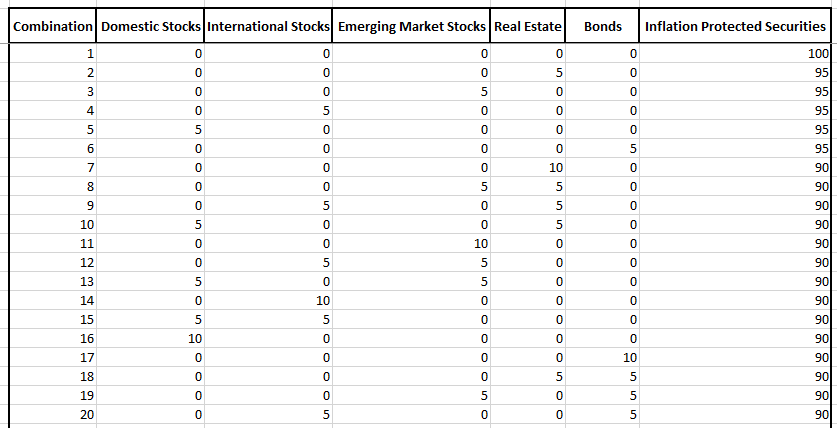


For combination 1 I would have a portfolio that would be 100% invested in an inflation protected securities index fund and 0% in all other asset classes. Over the course of a particular historical investing period I would be able to calculate an average annualized rate of return and a maximum annual loss. The same could then be done for combination 2, 3, and so on. So for a 6 asset portfolio assuming allocation percentage multiples of 5% this results in 53130 outputs for average annualized rate of return and maximum annual loss.


After compiling datasets for both institutions they can be compared for statistically significant differences using independent-samples t-test's. The results from the t-test's will be used to accept or reject the following null hypotheses:


1.   	$H_1$:  There is no significant difference in the average annualized returns between financial institutions 1 and 2.
2.   	$H_2$:  There is no significant difference in the maximum annual losses between financial institutions 1 and 2.


If one or both of the nulls can be rejected there will be causal evidence that one institution has a historically better performing index fund lineup than the other.


It should also be noted that this analysis calculates returns based on a single lump sum investment at the start of the investment period and assumes reinvestment of any dividends and capital gains distributions. 

#2. Accessing Data

There are two avenues used for loading data in this analysis. Importing from pre-assembled csv files and downloading data from [Yahoo Finance](https://finance.yahoo.com/). 

Csv files are accessed by linking Google Drive to Colaboratory:

In [ ]:
# Mount Google Drive to Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Data from Yahoo Finance is accessed via the yfinance library in Python. yfinance does not come preinstalled on Google Colaboratory but it can be easily installed using the following !pip install:

In [ ]:
# Install yfinance library. 
!pip install yfinance

     |████████████████████████████████| 6.3 MB 12.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=34368194ec4a46d5ec7599952c5725efc78249fa9553ee3b7137abcf2e26ffdf
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


Now the yfinance library can be imported using "import yfinance". Before proceeding any farther it is also wise to import any additional libraries or modules that will be needed for the analysis just to keep things organized.

In [ ]:
# Do all imports here to stay organized.  
import yfinance as yf
import pandas as pd
import datetime 
from datetime import timedelta
import calendar
import statistics as st
import numpy as np
import seaborn as sns 
sns.set()
import matplotlib.pyplot as plt
from scipy import stats
import math

At this point it is time to specify the funds to import for the analysis. The analysis allows for 6 funds to be used as inputs. In order to compare the two institutions as fairly as possible it is necessary to choose similar funds for each asset category. The following image provides the asset classes and corresponding funds chosen for this analysis:

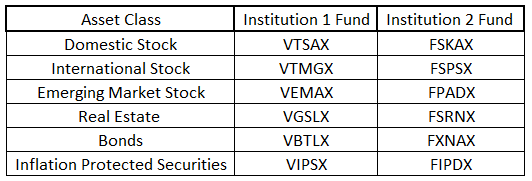

To begin the analysis the six tickers from one financial institution are assigned to the list named "tickers". When the data loading, wrangling, and calculations are complete for institution 1 and the results csv is exported we can come back to this step and repeat the process for institution 2. 

It is also necessary to select a start and end date for the investment period. The only requirements here are that the start date cannot be prior to the inception date of the youngest fund and the end date cannot be any later than the most recent round of closing prices.

The end result of this data loading step will be a DataFrame that contains a column for the date and 6 columns that contain the closing prices of all 6 funds.

In [ ]:
# REQUIRED INPUT: assign 6 ticker symbols to the 'tickers' list. (Must have exactly 6 tickers)
tickers = ['VTSAX', 'VTMGX', 'VEMAX', 'VGSLX', 'VBTLX', 'GC=F']

# Define start and end of investment period. (start_date cannot be earlier than the inception date of the youngest fund)
start_date = datetime.date(2006, 7, 1)
end_date = datetime.date(2021, 6, 30)

# Create a 1 day timedelta variable called "delta". Used for calculations involving datetime variables.  
delta = timedelta(days=1) 

# Download data from yahoo finance using yfinance.
all_data = yf.download(tickers, start=start_date, end=end_date + delta)

# Create new DataFrame called "closing_prices" and populate with date and closing prices.
closing_prices = pd.DataFrame()
closing_prices['Date'] = all_data.index
for ticker in tickers:
  closing_prices[ticker] = all_data['Close', ticker].values

# View first 5 rows in closing_prices DataFrame. Don't worry about null values just yet.
closing_prices.head()

[*********************100%***********************]  6 of 6 completed


,Date,VTSAX,VTMGX,VEMAX,VGSLX,VBTLX,GC=F
0,2006-06-30,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-07-03,30.980000,12.77,27.200001,95.370003,9.73,NaN
2,2006-07-05,30.730000,12.54,26.500000,95.349998,9.69,627.299988
3,2006-07-06,30.799999,12.65,26.709999,95.570000,9.71,634.099976
4,2006-07-07,30.559999,12.64,26.549999,95.120003,9.74,632.799988


#3. Data Wrangling

When viewing the dataframe there are a couple of things that stand out. First, there are missing dates in the "Date" column. Since these are assets that trade during market hours there is no data available for weekends and market holidays. It would be ideal to assign some data to those dates so that eventually the following calculation can be carried out without having to worry about null values:

$ROR_{@date} = \frac{Portfolio\,Value_{@date} - Portfolio\,Value_{@date-365}}{Portfolio\,Value_{@date-365}}$

The second issue is that there are "NaN" values present for active trading days. You can see that the 5th value for the asset VBTLX contains a "NaN" while all other assets have non-null values. This is a yfinance issue that apparently is not uncommon, and it seems to be very problematic for low volatility funds. The VBTLX fund, for example, is missing about 50% of the necessary closing price data. For the sake of this excercise I opted to manually download the data from yahoo finance in csv format and replace the null values that should have contained non-null's. This did render the yfinance portion of this analysis a little pointless but it did allow me to get some additional practice working with new libraries and manipulating DataFrames. 

Here is how the general process for addressing these 2 issues goes:


1.   Get missing dates into the DataFrame.
2.   Load csv files containing missing closing price data and distribution (dividend and capital gains) data.
3.   Replace 'NaN' values on active trading days with true values from imported data and add distribution columns to DataFrame.
4.   Fill 'NaN' values for weekends and holidays by averaging adjacent non-null values.

Let's first get our missing dates into the DataFrame. 



In [ ]:
# Create a list called "date_list" and populate with each date from start_date to end_date. 
date_list = []
current_date = start_date - delta 
while current_date <= end_date - delta:
  date_list.append(current_date + delta)
  current_date = current_date + delta

# Create a list called "day_list" and populate with corresponding weekday names for each date in date_list. 
day_list = []
for date in date_list:
  weekday = date.weekday()
  day_name = calendar.day_name[weekday]
  day_list.append(day_name)

# Create a new DataFrame called "df" that is identical to the closing_prices DataFrame but now includes day names and the dates of non-trading days.
dates_df = pd.DataFrame(list(zip(date_list, day_list)), columns = ['Date', 'Day'])
dates_df['Date'] = pd.to_datetime(dates_df['Date'])
df = pd.merge(dates_df, closing_prices, how='left', on='Date')

# View first 5 rows in df DataFrame. Don't worry about null values just yet.
df.head()

,Date,Day,VTSAX,VTMGX,VEMAX,VGSLX,VBTLX,GC=F
0,2006-07-01,Saturday,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-07-02,Sunday,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-07-03,Monday,30.98,12.77,27.200001,95.370003,9.73,NaN
3,2006-07-04,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-07-05,Wednesday,30.73,12.54,26.500000,95.349998,9.69,627.299988


As you can see there are now dates for Saturday and Sunday. The next code block involves filling in any "NaN" values and adding colunns for respective fund distributions. Before proceeding it is important to note that a csv file is required. Go ahead and use the provided csv file titled "institution_1_reference_data" for institution 1. When repeating the process for institution 2 replace the file with "institution_2_reference_data". At the end of this step you should now have a DataFrame with closing prices and distribution amounts for every date in the investing period and no "NaN" values.

In [ ]:
# Import csv file that contains missing closing prices and distribution data (dividends and capital gains distributions).
# Convert csv file to a DataFrame called "ref_df".
ref_df = pd.read_csv('/content/gdrive/My Drive/capstone_3_csv_files/reference_for_project.csv')
ref_df['Date'] = pd.to_datetime(ref_df['Date'])

# Update df DataFrame to include data from ref_df DataFrame. 
df = pd.merge(df, ref_df, how='left', on='Date')
for ticker in tickers:
  df.loc[df[ticker].isnull(), ticker] = df[ticker + '_REF']
  df.loc[df[ticker + '_DIST'].isnull(), ticker + '_DIST'] = 0
df = df.drop(df.filter(regex='_REF').columns, axis=1)

# Populate remaining null values (non-trading days) with mean of adjacent non-null values.
df = pd.concat([df.ffill(), df.bfill()]).groupby(level=0).mean()

# Create final raw data DataFrame called "df_final" by merging dates_df and df DataFrames. 
# df_final DataFrame should now include day names, closing prices, and distribution data for every day from start_date to end_date with no null values.
df_final = pd.merge(dates_df, df, left_index=True, right_index=True)

# View first 5 rows in df_final DataFrame.
df_final.head()

,Date,Day,VTSAX,VTMGX,VEMAX,VGSLX,VBTLX,GC=F,VTSAX_DIST,VTMGX_DIST,VEMAX_DIST,VGSLX_DIST,VBTLX_DIST,VIPSX_DIST,GC=F_DIST
0,2006-07-01,Saturday,30.980,12.770,27.200001,95.370003,9.73,620.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2006-07-02,Sunday,30.980,12.770,27.200001,95.370003,9.73,620.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2006-07-03,Monday,30.980,12.770,27.200001,95.370003,9.73,620.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2006-07-04,Tuesday,30.855,12.655,26.850000,95.360001,9.71,623.849994,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2006-07-05,Wednesday,30.730,12.540,26.500000,95.349998,9.69,627.299988,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_final.to_csv('/content/gdrive/My Drive/capstone_3_csv_files/test.csv')

#4. Calculations

Remember from earlier that we are after 2 outputs of interest:


1.   Annualized Rate of Return
2.   Maximum Annual Loss

And what we ultimately are after is both of these outputs for each of our 53130 asset allocation combinations. The calculations to get these outputs are not the most complex, but there are a lot of moving parts. The general workflow looks like this:


1.   Assign an amount to invest at the start of the investing period. As long as this is a positive value it does not really matter what the number is since we are really after %changes. For this analysis I suggest using a simple value like 10000.
2.   Calculate number of starting shares for each asset using the following equation:

  $Starting\,Shares=\frac{Initial\,Investment\,\times\,Percent\,Allocation}{Share\,Price_{@startdate}}$
    

3.   Calculate number of shares of each asset for every date in the investing period. This step is needed to account for the reinvestment of dividends and capital gains distributions. Number of shares at each date can be calculated using the following:

  $Quantity\,of\,Shares_{@date}=Quantity\,of\,Shares_{@date-1}+Quantity\,of\,Shares_{@date-1}\times\frac{Distribution\,Per\,Share_{@date}}{Share\,Price_{@date}}$

4.   Calculate total value of portfolio for every date in the investing period by summing the value of each asset in the portfolio.

  $Portfolio\,Value_{@date}=\sum_\limits{n=1}^{6}(Quantity\,of\,Shares\,of\,Fund\,n_{@date})\times(Share\,Price\,of\,Fund\,n_{@date})$

5.   Then, beginning exatly 365 days after the start of the investing period we can begin calculating a running 365 day rate of return as follows:

  $ROR_{@date} = \frac{Portfolio\,Value_{@date} - Portfolio\,Value_{@date-365}}{Portfolio\,Value_{@date-365}}$

6.   At this point there should be a ROR value for every date in the date range ((Start Date + 365) to End Date). Our outputs of interest can now be calculated in the following way:

  $Annualized\,ROR=[(1+ROR_{1})\times(1+ROR_{2})\times...\times(1+ROR_{n})]^{1/n}-1$

  $Maximum\,Annual\,Loss=Minimum(ROR_{1}, ROR_{2},..., ROR_{n})$

7.  Repeat the process for the remaining asset allocation combinations. The final output will contain 53130 rows of calculated data.

The code used to calculate these results is broken down into four blocks. Block one requires a csv titled "asset_combinations" to be loaded and an initial investment amount specified. The end result is a DataFrame that contains the beginning number of shares of each asset for every asset allocation combination.


In [ ]:
# Import csv file that contains all unique combinations of asset allocation for 6 assets (53130 combinations). 
# Convert csv file to a DataFrame called "combinations_df". 
combinations_df = pd.read_csv('/content/gdrive/My Drive/capstone_3_csv_files/asset_combinations.csv')

# Define initial investment amount used to purchase shares on start_date.
initial_investment = 10000

# Create a new DataFrame called "combinations_df_edit" that includes the beginning quantity of shares for each asset allocation combination. 
initial_share_prices = []
for ticker in tickers:
  initial_share_price = df_final[ticker].iloc[0]
  initial_share_prices.append(initial_share_price)

combinations_df_edit = combinations_df.assign(asset_1_initial_shares = combinations_df['asset_1']*initial_investment/initial_share_prices[0],
                                         asset_2_initial_shares = combinations_df['asset_2']*initial_investment/initial_share_prices[1],
                                         asset_3_initial_shares = combinations_df['asset_3']*initial_investment/initial_share_prices[2],
                                         asset_4_initial_shares = combinations_df['asset_4']*initial_investment/initial_share_prices[3],
                                         asset_5_initial_shares = combinations_df['asset_5']*initial_investment/initial_share_prices[4],
                                         asset_6_initial_shares = combinations_df['asset_6']*initial_investment/initial_share_prices[5])

combinations_df_edit = combinations_df_edit.drop(['Combination', 'asset_1', 'asset_2', 'asset_3', 'asset_4', 'asset_5', 'asset_6'], axis = 1)

# View first 5 rows in combinations_df_edit DataFrame.
combinations_df_edit.head()

,asset_1_initial_shares,asset_2_initial_shares,asset_3_initial_shares,asset_4_initial_shares,asset_5_initial_shares,asset_6_initial_shares
0,0.000000,0.000000,0.000000,0.000000,0.0,16.118633
1,0.000000,0.000000,0.000000,5.242739,0.0,15.312701
2,0.000000,0.000000,18.382352,0.000000,0.0,15.312701
3,0.000000,39.154266,0.000000,0.000000,0.0,15.312701
4,16.139445,0.000000,0.000000,0.000000,0.0,15.312701


Block 2 is a preparation step that extracts closing prices and distribution data from the DataFrame and assembles it in a list format. I initially wanted to do all the calculations within the DataFrame but it was too time consuming when running for loops so I opted to extract the data into these list formats. 

In [ ]:
# Create a list of lists for each asset that includes closing price and distribution amount for each date in the investing period.
# Each nested list should have the format ['closing price', 'distribution amount']

# Extract closing price and distribution data from df_final DataFrame.
# Asset 1
ticker_1_prices = df_final[tickers[0]].tolist()
ticker_1_dist = df_final[tickers[0] + '_DIST'].tolist()

# Asset 2
ticker_2_prices = df_final[tickers[1]].tolist()
ticker_2_dist = df_final[tickers[1] + '_DIST'].tolist()

# Asset 3
ticker_3_prices = df_final[tickers[2]].tolist()
ticker_3_dist = df_final[tickers[2] + '_DIST'].tolist()

# Asset 4
ticker_4_prices = df_final[tickers[3]].tolist()
ticker_4_dist = df_final[tickers[3] + '_DIST'].tolist()

# Asset 5
ticker_5_prices = df_final[tickers[4]].tolist()
ticker_5_dist = df_final[tickers[4] + '_DIST'].tolist()

# Asset 6
ticker_6_prices = df_final[tickers[5]].tolist()
ticker_6_dist = df_final[tickers[5] + '_DIST'].tolist()

# Create function called "merge" that combines closing price and distribution data into a single list.
def merge(list1, list2):
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

# Use new merge function to create lists for each of the 6 assets. 
ticker_1_info = merge(ticker_1_prices, ticker_1_dist)
ticker_2_info = merge(ticker_2_prices, ticker_2_dist)
ticker_3_info = merge(ticker_3_prices, ticker_3_dist)
ticker_4_info = merge(ticker_4_prices, ticker_4_dist)
ticker_5_info = merge(ticker_5_prices, ticker_5_dist)
ticker_6_info = merge(ticker_6_prices, ticker_6_dist)

# Print first 5 items in ticker_1_info to make sure format is correct. 
print(ticker_1_info[:5])

[(30.979999542236328, 0.0), (30.979999542236328, 0.0), (30.979999542236328, 0.0), (30.854999542236328, 0.0), (30.729999542236328, 0.0)]


Block 3 defines a function that will calculate the quantity of shares of each fund for every date in the investing period. This step captures the changes in share quantity as a result of reinvested dividends and capital gains distributions.

In [ ]:
# Create a function that returns the number of shares of each asset for every date in the investing period.
def calc_shares(info_1, info_2, info_3, info_4, info_5, info_6, initial_shares):
  # Create empty lists to populate for each asset.
  ticker_1_shares, ticker_2_shares, ticker_3_shares, ticker_4_shares, ticker_5_shares, ticker_6_shares = [], [], [], [], [], []
  # Assign initial quantity of shares for each asset.
  ticker_1_current_shares, ticker_2_current_shares, ticker_3_current_shares, ticker_4_current_shares, ticker_5_current_shares, ticker_6_current_shares = initial_shares[0], initial_shares[1], initial_shares[2], initial_shares[3], initial_shares[4], initial_shares[5]

  # Calculate number of shares of each asset for every date in the investing period.
  # Asset 1
  for a in info_1:
    ticker_1_current_shares = ticker_1_current_shares + ticker_1_current_shares * a[1] / a[0]
    ticker_1_shares.append(ticker_1_current_shares)

  # Asset 2
  for b in info_2:
    ticker_2_current_shares = ticker_2_current_shares + ticker_2_current_shares * b[1] / b[0]
    ticker_2_shares.append(ticker_2_current_shares)

  # Asset 3
  for c in info_3:
    ticker_3_current_shares = ticker_3_current_shares + ticker_3_current_shares * c[1] / c[0]
    ticker_3_shares.append(ticker_3_current_shares)

  # Asset 4
  for d in info_4:
    ticker_4_current_shares = ticker_4_current_shares + ticker_4_current_shares * d[1] / d[0]
    ticker_4_shares.append(ticker_4_current_shares)

  # Asset 5
  for e in info_5:
    ticker_5_current_shares = ticker_5_current_shares + ticker_5_current_shares * e[1] / e[0]
    ticker_5_shares.append(ticker_5_current_shares)

  # Asset 6
  for f in info_6:
    ticker_6_current_shares = ticker_6_current_shares + ticker_6_current_shares * f[1] / f[0]
    ticker_6_shares.append(ticker_6_current_shares)

  # Return a list of lists with each nested list containing the number of shares of each asset for every date in the investing period.
  return ticker_1_shares, ticker_2_shares, ticker_3_shares, ticker_4_shares, ticker_5_shares, ticker_6_shares

Block 4 is where everything comes together. Here I incorporate my extracted closing price and distribution lists with the function for calculating share quantity and then cycle through every asset allocation combination with a for loop. There are 3 results lists returned in this block. The two lists we are interested in are the Average Annualized Rates of Return contained in the list named "Avg_AnROR_List" and the Maximum Annual Losses contained in the list named "Max_Loss_List". 

It should also be noted that this block takes approximately 20 minutes to finish processing.

In [ ]:
# WARNING: Cell takes approximately 20 minutes to run.

# Use a combination of for looping and the calc_shares function to create outputs of interest for each asset allocation combination.
# Returns 3 outputs of interest: Average Annual Return, Average Annualized Return, and Maximum Annual Loss
# Each output is a list containing a value for each unique asset allocation combination.

# Ensure df_final DataFrame is set to the correct starting format.
df_final = pd.merge(dates_df, df, left_index=True, right_index=True)
# Convert combinations_df_edit DataFrame to a list called "combinations". (Will be used for the calc_shares function)
combinations = combinations_df_edit.to_numpy().tolist()
# Create empty lists for the 3 outputs of interest.
Avg_AROR_List = []
Avg_AnROR_List = []
Max_Loss_List = []

# Loop through each asset allocation combination.
for combination in combinations:
  # Use the calc_shares function to calculate number of shares of each asset for every date in the investing period.
  all_shares = calc_shares(ticker_1_info, ticker_2_info, ticker_3_info, ticker_4_info, ticker_5_info, ticker_6_info, combination)

  # Add 6 new columns to df_final DataFrame that give the number of shares of each asset for every date in the investing period.
  df_final['ASSET_1_SHARES']= all_shares[0]
  df_final['ASSET_2_SHARES']= all_shares[1]
  df_final['ASSET_3_SHARES']= all_shares[2]
  df_final['ASSET_4_SHARES']= all_shares[3]
  df_final['ASSET_5_SHARES']= all_shares[4]
  df_final['ASSET_6_SHARES']= all_shares[5]

  # Calculate total portfolio value at every date in the investing period.
  df_final['TOTAL_VALUE'] = df_final[tickers[0]] * df_final['ASSET_1_SHARES'] + df_final[tickers[1]] * df_final['ASSET_2_SHARES'] + df_final[tickers[2]] * df_final['ASSET_3_SHARES'] + df_final[tickers[3]] * df_final['ASSET_4_SHARES'] + df_final[tickers[4]] * df_final['ASSET_5_SHARES'] + df_final[tickers[5]] * df_final['ASSET_6_SHARES']
  # Calculate a running 365 day rate of return.
  df_final['AROR'] = (df_final['TOTAL_VALUE'] - df_final['TOTAL_VALUE'].shift(365)) / df_final['TOTAL_VALUE'].shift(365)
  # Drop the first year worth of rate of return values as these will be null values.
  df_final.drop(index=df_final.index[:365], axis=0, inplace=True)
  # Create new column used for calculating annualized rate of return.
  df_final['GMean_Value'] = 1 + df_final['AROR']

  # Calculate average annual rate of return and append to the appropriate output list.
  Avg_AROR = df_final['AROR'].mean()
  Avg_AROR_Perc = round(Avg_AROR * 100, 2)
  Avg_AROR_List.append(Avg_AROR_Perc)

  # Calculate average annualized rate of return and append to the appropriate output list.
  Avg_AnROR = ((df_final['GMean_Value'].product())**(1/len(df_final)))-1
  Avg_AnROR_Perc = round(Avg_AnROR * 100, 2)
  Avg_AnROR_List.append(Avg_AnROR_Perc)

  # Calculate maximum loss and append to the appropriate output list.
  Max_Loss = df_final['AROR'].min()
  Max_Loss_Perc = round(Max_Loss * 100, 2)
  Max_Loss_List.append(Max_Loss_Perc)

  # Reset df_final DataFrame to the correct starting format before returning to the beginning of the loop.
  df_final = pd.merge(dates_df, df, left_index=True, right_index=True)

The results can now be appended back into the original asset allocation combination DataFrame and exported to a csv file for future use. At this point we now have the final dataset for institution 1. To get the dataset for institution 2 it is necessary to repeat the data loading, wrangling, and calculations steps with the necessary inputs for institution 2.

In [ ]:
# Add results outputs to the original combinations_df DataFrame.
combinations_df['Avg_AROR'] = Avg_AROR_List
combinations_df['Avg_AnROR'] = Avg_AnROR_List
combinations_df['Max_Loss'] = Max_Loss_List

# Export combinations_df DataFrame as a csv file if so desired.
combinations_df.to_csv('/content/gdrive/My Drive/capstone_3_csv_files/project_combinations2.csv')

# View the first 5 rows of combinations_df DataFrame.
# DataFrame should include asset allocation details as well as columns for average annual return, average annualized return, and maximum loss.
combinations_df.head()


,Combination,asset_1,asset_2,asset_3,asset_4,asset_5,asset_6,Avg_AROR,Avg_AnROR,Max_Loss
0,AAAAAU,0.00,0.00,0.00,0.00,0.0,1.00,2.93,2.76,-13.39
1,AAABAT,0.00,0.00,0.00,0.05,0.0,0.95,3.08,2.90,-14.96
2,AABAAT,0.00,0.00,0.05,0.00,0.0,0.95,3.07,2.88,-16.34
3,ABAAAT,0.00,0.05,0.00,0.00,0.0,0.95,2.96,2.79,-15.21
4,BAAAAT,0.05,0.00,0.00,0.00,0.0,0.95,3.48,3.31,-14.69


#5. Statistical Analysis

With the final datasets now assembled it is time to conduct the statistical analysis to determine which institution has the better performing lineup of funds. The final calculated variables can be accessed using the csv file called 'final_combined_outputs_updated'. This csv file contains the quantitative variables average annualized rate of return (Avg_AnROR) and maximum annual loss (Max_Loss), and a categorical variable that identifies the financial institution (Institution). 



In [ ]:
# Import csv file containing average annual rate of return, average annualized rate of return, and max loss data for both financial institutions.
# Convert csv file into a DataFrame called results_df
results_df = pd.read_csv('/content/gdrive/My Drive/capstone_3_csv_files/final_combined_outputs_updated.csv')

# Create separate data frames for institutions 1 and 2 using the categorical variable 'Institution'.
results_institution_1 = results_df.iloc[(results_df['Institution'] == 'Institution_1').values]
results_institution_2 = results_df.iloc[(results_df['Institution'] == 'Institution_2').values]

# View the first 5 rows of results_df DataFrame.
results_df.head()

,Avg_AnROR,Max_Loss,Institution
0,1.86,-9.60,Institution_1
1,2.22,-8.87,Institution_1
2,2.02,-9.25,Institution_1
3,2.19,-7.94,Institution_1
4,2.87,-7.54,Institution_1


Before proceeding to the t-test analyses let's have a look at the descriptive statistics for institution 1.

In [ ]:
# Calculate summary statistics for all variables.
results_institution_1[['Avg_AnROR', 'Max_Loss']].describe()

,Avg_AnROR,Max_Loss
count,53130.000000,53130.000000
mean,7.036789,-17.462573
std,1.937830,5.450648
min,1.860000,-30.990000
25%,5.640000,-21.560000
50%,6.820000,-18.120000
75%,8.260000,-13.840000
max,14.550000,-1.950000


And now institution 2.

In [ ]:
results_institution_2[['Avg_AnROR', 'Max_Loss']].describe()

,Avg_AnROR,Max_Loss
count,53130.000000,53130.000000
mean,6.786115,-18.243626
std,1.924360,5.945743
min,2.160000,-36.730000
25%,5.370000,-22.450000
50%,6.490000,-18.700000
75%,7.990000,-14.270000
max,14.510000,-1.930000


The range of Avg_AnROR values appear to be fairly similar for both institutions although institution 1 does have a slightly higher mean Avg_AnROR at 7.04% vs 6.79%. For Max_Loss Institution 2 has a wider range of values with a majority of the additional range coming in on the low side. Institution 2 also has a higher average Max_Loss than Institution 1 at -18.24% vs - 17.46%.

Let's have a look at the density curves and box plots of each variable to see if anything else stands out.

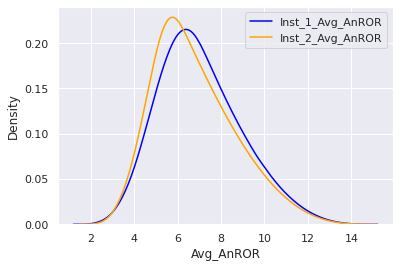

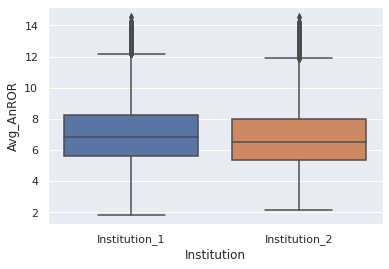

In [ ]:
# Generate density plots for the annualized rates of returns for both institutions.
sns.kdeplot(results_institution_1['Avg_AnROR'], color="blue", label="Inst_1_Avg_AnROR")
sns.kdeplot(results_institution_2['Avg_AnROR'], color="orange", label="Inst_2_Avg_AnROR")

plt.legend() 
plt.show()

# Generate box plots for the annualized rates of returns for both institutions.
sns.boxplot(y='Avg_AnROR', x="Institution", data=results_df)

The visualizations for Avg_AnROR support the summary statistics. The range of values are quite similar with a slight difference in the mean of Avg_AnROR between the two institutions. Additionally, the density curves appear to be fairly normally distriuted with just a slight right skew which is also supported by the box plots with a few outliers appearing on the high side.

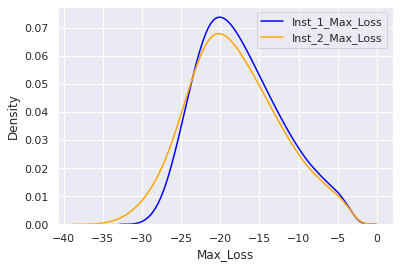

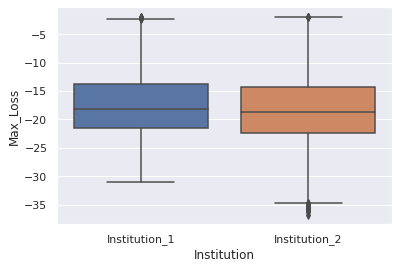

In [ ]:
# Generate density plots for the max losses for both institutions.
sns.kdeplot(results_institution_1['Max_Loss'], color="blue", label="Inst_1_Max_Loss")
sns.kdeplot(results_institution_2['Max_Loss'], color="orange", label="Inst_2_Max_Loss")

plt.legend() 
plt.show()

# Generate box plots for the max_losses for both institutions.
sns.boxplot(y='Max_Loss', x="Institution", data=results_df)

The visualizations for Max_Loss also support the summary statistics. The most apparent takeway is the extended range of values to the low side for Institution 2. Additionally the Max_Loss variables appear to be very close to normally distributed.

But now to the question we really want the answer to. The descriptive statistics and visualizations show that there is a difference between the means of both variables. Institution 1 has higher average returns and lower maximum losses, but are they actually statistically significant? 

Before we run our t-tests let's do one last check on the variables to make sure they are appropriate for t-test analysis. Visually they appear to be nearly normally distributed but a quick check on the skewness and kurtosis will let us know for sure. Ideally we want to see skewness values between -1 and 1 and kurtosis values between -2 and 2 before proceeding.



In [ ]:
# Calculate skewness and kurtosis for Avg_AnROR
print('The skewness of Avg_AnROR for institution 1 is {}.'.format(stats.skew(results_institution_1['Avg_AnROR'], bias=False)))
print('The skewness of Avg_AnROR for institution 2 is {}.'.format(stats.skew(results_institution_2['Avg_AnROR'], bias=False)))
print('The kurtosis of Avg_AnROR for institution 1 is {}.'.format(stats.kurtosis(results_institution_1['Avg_AnROR'], bias=False)))
print('The kurtosis of Avg_AnROR for institution 2 is {}.'.format(stats.kurtosis(results_institution_2['Avg_AnROR'], bias=False)))

The skewness of Avg_AnROR for institution 1 is 0.4698588211838533.
The skewness of Avg_AnROR for institution 2 is 0.619123393639602.
The kurtosis of Avg_AnROR for institution 1 is -0.04270862486544358.
The kurtosis of Avg_AnROR for institution 2 is 0.0539759256108483.


In [ ]:
# Calculate skewness and kurtosis for Max_Loss
print('The skewness of Max_Loss for institution 1 is {}.'.format(stats.skew(results_institution_1['Max_Loss'], bias=False)))
print('The skewness of Max_Loss for institution 2 is {}.'.format(stats.skew(results_institution_2['Max_Loss'], bias=False)))
print('The kurtosis of Max_Loss for institution 1 is {}.'.format(stats.kurtosis(results_institution_1['Max_Loss'], bias=False)))
print('The kurtosis of Max_Loss for institution 2 is {}.'.format(stats.kurtosis(results_institution_2['Max_Loss'], bias=False)))

The skewness of Max_Loss for institution 1 is 0.42143617725379007.
The skewness of Max_Loss for institution 2 is 0.22497396492064478.
The kurtosis of Max_Loss for institution 1 is -0.4019936245991471.
The kurtosis of Max_Loss for institution 2 is -0.31714952631709714.


All variables check out, so it is now time to perform the independent samples t-tests for both variables.

In [ ]:
# Perform independent-samples t-test on Avg_AnROR between the two institutions.
stats.ttest_ind(results_institution_1['Avg_AnROR'], results_institution_2['Avg_AnROR'])

Ttest_indResult(statistic=21.157218558392874, pvalue=3.796905266326624e-99)

In [ ]:
# Create a function to calculate the 95% confidence interval between the means of two variables.
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

# Find the 95% confidence interval for average annualized rate of return.
get_95_ci(results_institution_1['Avg_AnROR'], results_institution_2['Avg_AnROR'])

'The difference in means at the 95% confidence interval (two-tail) is between 0.22745196470119255 and 0.27389680247373205.'

Based on the results of the t test on Avg_AnROR we reject the null hypothesis that there is no significant difference in the average annualized returns between financial institutions 1 and 2. The results are significant with a p value much less than .05. With 95% confidence the difference in the means is between 0.23% and 0.27%.

Institution 1 does indeed have statistically higher historic returns over the given investment period that Institution 2 does.

In [ ]:
# Perform independent-samples t-test on Max_Loss between the two institutions.
stats.ttest_ind(results_institution_1['Max_Loss'], results_institution_2['Max_Loss'])

Ttest_indResult(statistic=22.31972284740483, pvalue=4.2652378951621344e-110)

In [ ]:
# Find the 95% confidence interval for the maximum annual loss.
get_95_ci(results_institution_2['Max_Loss'], results_institution_1['Max_Loss'])

'The difference in means at the 95% confidence interval (two-tail) is between 0.7124652991833527 and 0.8496412319664985.'

Based on the results of the t test on Max_Loss we reject the null hypothesis that there is no significant difference in the maximum annual losses between financial institutions 1 and 2. The results are significant with a p value much less than .05. With 95% confidence the difference in the means is between 0.71% and 0.85%.

Institution 1 does indeed have statistically lower maximum losses over the given investment period that Institution 2 does.

#6 Takeaways and Conclusion

The statistical analysis in the previous section has shown that for the given investing period Institution 1 has a fund lineup that performs statistically better than institution 2 in terms of both average annualized returns and maximum annual losses. This could be valuable information to know for both the individual investor who is deciding which institution to choose for their personal investing needs as well as for either of the institutions in question. For the better performing institution this is great to know for advertising purposes. Never hurts to have data to back up that you are performing better than the competition. On the other hand, for the poorer performing institution this could serve as a call to action to improve their index fund methodology. 

Before getting too carried away though, as with any statistical analysis, it is always a good idea to get an idea of the magnitude of effects. Just because something is statistically significant does not mean that it is practically significant. As an example lets consider two individuals that begin investing in Roth IRA's when they are 25. Both contribute $6000 annually and allow their investments to grow for 40 years until retirement at 65. The first individual invests in an average portfolio of Institution 1 funds that yields an average annualized rate of return of 7.04%. The first individual invests in an average portfolio of Institution 2 funds that yields an average annualized rate of return of 6.79%. Lets have a look at the value of their respective portfolios at retirement.

In [ ]:
# Calculate the impact of an average Institution 1 and 2 portfolio assuming 40 years of growth and annual contributions of $6000.
start_year = 25
end_year = 65
current_year = start_year - 1
years = []
while current_year < end_year:
  year = current_year + 1
  current_year = current_year + 1
  years.append(year)

ROI_df = pd.DataFrame(years, columns=['Year'])
ROI_df['Investment_Amount'] = 6000

ROI_df.loc[ROI_df.index[0], 'Institution_1_Value'] = ROI_df.loc[ROI_df.index[0], 'Investment_Amount'] + ROI_df.loc[ROI_df.index[0], 'Investment_Amount'] * .0704 
ROI_df.loc[ROI_df.index[0], 'Institution_2_Value'] = ROI_df.loc[ROI_df.index[0], 'Investment_Amount'] + ROI_df.loc[ROI_df.index[0], 'Investment_Amount'] * .0679

for i in range(1, len(ROI_df)):
  ROI_df.loc[i, 'Institution_1_Value'] = (ROI_df.loc[i-1, 'Institution_1_Value'] + ROI_df.loc[i, 'Investment_Amount']) * 1.0704

for i in range(1, len(ROI_df)):
  ROI_df.loc[i, 'Institution_2_Value'] = (ROI_df.loc[i-1, 'Institution_2_Value'] + ROI_df.loc[i, 'Investment_Amount']) * 1.0679

print('The average value of an Institution 1 portfolio going into retirement is approximately ${}'.format(round(ROI_df.loc[ROI_df.index[40], 'Institution_1_Value']), 2))
print('The average value of an Institution 2 portfolio going into retirement is approximately ${}'.format(round(ROI_df.loc[ROI_df.index[40], 'Institution_2_Value']), 2))


The average value of an Institution 1 portfolio going into retirement is approximately $1393049
The average value of an Institution 2 portfolio going into retirement is approximately $1300609


The first individual is going into retirement with a portfolio value of approximately 1.39 million while the second individual is going into retirement with a portfolio value of approximately 1.3 million. The $90000 difference could support an additional year or two of expenses depending on the retired individuals lifestyle. I would say that is a significant practical effect. 

In closing I would like to briefly highlight one more thing that this analysis provides. Once an individual has decided which financial institution they prefer they can use these outputs to also determine their ideal asset allocation combination. The following figure is a scatterplot of the maximum loss vs average annualized return for each asset allocation combination for institution 1. Individuals can specify their desired minimum annual rate of return and then identify the combination that historically has had the lowest annual losses. Take for example someone that would like at least an average annualized rate of return of 8%. Many portfolios have earned 8% but the range of losses goes all the way from about -7.5% to -30%! I personally am going with the portfolio that historically has done a better job weathering the financial storms. 

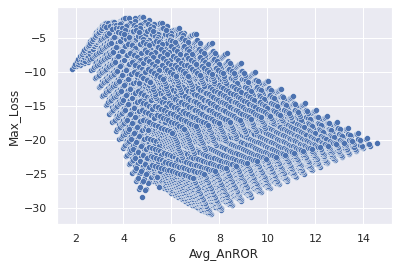

In [ ]:
# Generate a scatterplot of Max_Loss vs Avg_AnROR for institution 1.
sns.scatterplot(x='Avg_AnROR', y='Max_Loss', data=results_institution_1)

#AND LASTLY


1.   I am not a financial advisor and as such the results of this analysis should not be considered investment advice.
2.   Historic performance may not be indicative of future results.

